In [7]:
import torch
import monte_carlo
import tv_bound_algorithm as algorithm

from dynamics import LinearDynamics
from distributions import GaussianMixture, Gaussian

### **Example 1: The linear bimodal case** 

In this experiement, $x_0$ follows a GMM with two components, and the system is linear $f(x_t) = Ax_{t}$. We assume $\varepsilon_t$ to be normally distributed, with a fixed stationary covariance, i.e. $\varepsilon_t \sim \mathcal{N}([0, 0], \Sigma_{\varepsilon})$.

See Experimental Results in the paper for further details.

#### 1) Parameters

##### 1.1) System parameters

In [8]:
# Dynamics parameters
A = torch.Tensor(
        [
            [0.84, 0.1],
            [0.05, 0.72]
        ])

# Initial distribution parameters
initial_weights = torch.Tensor([0.5, 0.5])
initial_means = torch.Tensor([[8, 10], [6, 10]])
sigma = 0.005
cov = sigma * torch.eye(2)
initial_covariances = torch.stack((cov, cov), dim=0)

# Noise
mean_noise = torch.Tensor([0, 0])
sigma_noise = 0.01
cov_noise = sigma_noise * torch.eye(2)  # Assumes uncorrelation (this could be relaxed in further upgrades)

# Barrier (unsafe set)
barrier = torch.Tensor([[3.5, 2.0], [4.5, 3.0]])

##### 1.1) Simulation parameters

In [9]:
# Time horizon
n_steps_ahead = 5

# Monte Carlo simulation
n_samples = 10000

# Grid parameters
grid_type = "adaptative_grid" #if 'uniform_grid', set n_refinements to zero
min_proportion = 0.01
min_size = 0.001
max_depth = 3 #only used if 'uniform_grid' is chosen

# Refinement
threshold = 1e-7
n_refinements = 3

In [10]:
torch.manual_seed(0) # for reproducibility

f = LinearDynamics(A)

initial_distribution = GaussianMixture(initial_means, initial_covariances, initial_weights)
noise_distribution = Gaussian(mean_noise, cov_noise)

##### 2) Monte Carlo simulation of the system

We run a Monte Carlo simulation for the system above in order to understand its probabilistic behavior.

We also add a representation of an unsafe set (red square) which is motivated in subsection B of Experimental Results in the paper.

Hitting probability: 0.0000
Hitting probability: 0.0000
Hitting probability: 0.0000
Hitting probability: 0.0000
Hitting probability: 0.0000
Hitting probability: 0.1713


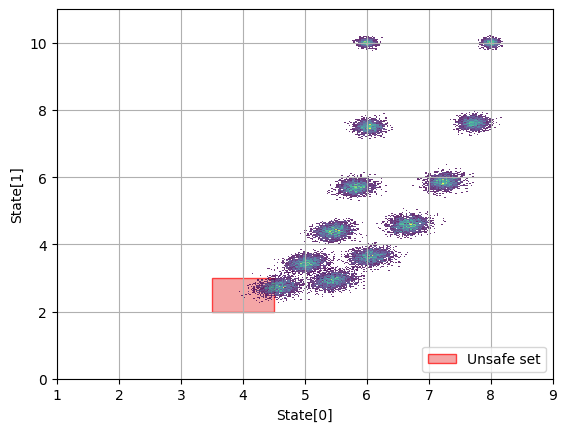

[0.0, 0.0, 0.0, 0.0, 0.0, 0.1713]

In [11]:
monte_carlo.monte_carlo_simulation(f, initial_distribution, noise_distribution, barrier, n_steps_ahead, n_samples)

##### 3) Computing TV bounds

In [12]:
tv_bounds_time_step, gmms = algorithm.tv_bound_algorithm(f, initial_distribution, noise_distribution, grid_type)
tv_bounds = torch.cumsum(tv_bounds_time_step, dim=0)
tv_bounds = torch.minimum(tv_bounds, torch.tensor(1))
print(f"Final TV bounds: {tv_bounds}")

Number of regions: 280
Function 'compute_signature_probabilities' executed in 0.0627s
TV bound at propag step: 0.1339588165283203
Number of regions: 244
Function 'compute_signature_probabilities' executed in 0.0027s
TV bound at propag step: 0.18779365718364716
Number of regions: 232
Function 'compute_signature_probabilities' executed in 0.0026s
TV bound at propag step: 0.2028760462999344
Number of regions: 223
Function 'compute_signature_probabilities' executed in 0.0030s
TV bound at propag step: 0.2102729231119156
Number of regions: 211
Function 'compute_signature_probabilities' executed in 0.0030s
TV bound at propag step: 0.2157934606075287
Final TV bounds: tensor([0.0000, 0.1340, 0.3218, 0.5246, 0.7349, 0.9507])


##### 4) Compare unsafe set hitting probabilities

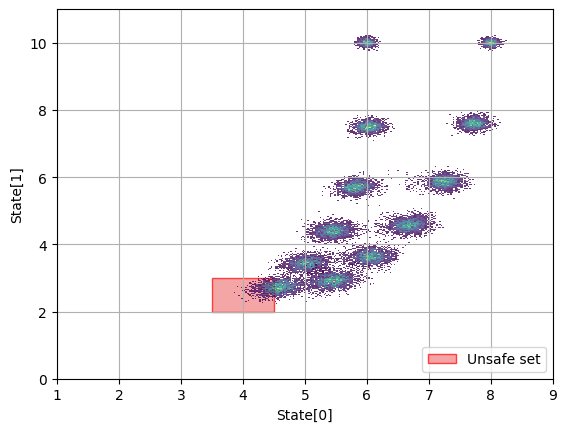

GMM hitting probs: [0.0, 0.0, 0.0, 0.0, 1.3438051610137336e-05, 0.17636829614639282]


In [13]:
gmm_hitting_probs = monte_carlo.gmm_approximation_monte_carlo(gmms, barrier, n_samples)
print(f"GMM hitting probs: {gmm_hitting_probs}")